In [50]:
import torch
import torchvision
from torchvision.transforms import transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt

In [51]:
training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


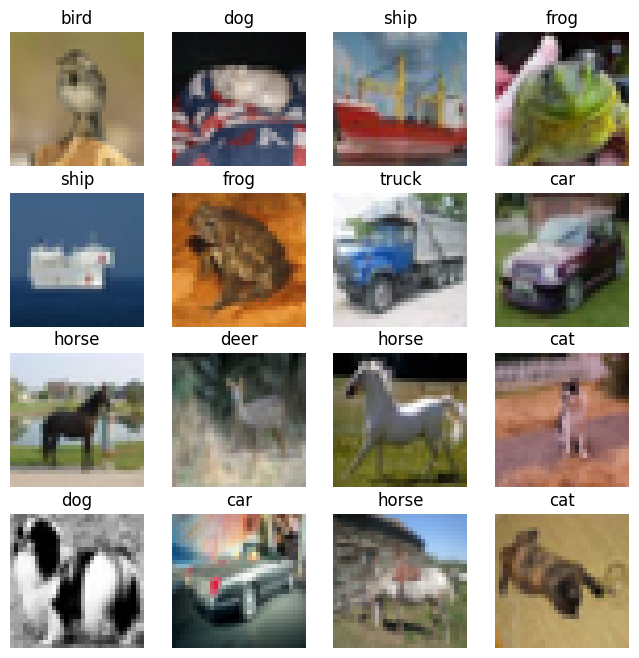

In [52]:
labels_map = {
              0:'plane',
              1:'car',
              2:'bird',
              3:'cat',
              4:'deer',
              5:'dog',
              6:'frog',
              7:'horse',
              8:'ship',
              9:'truck'}

figure = plt.figure(figsize=(8,8))
cols, rows = 4,4
for i in range(1, cols * rows +1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  figure.add_subplot(rows, cols, i)
  img, label = training_data[sample_idx]
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.permute(1,2,0))

plt.show()

In [53]:
import pandas as pd
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self, data, transforms=None):
    self.data = data
    self.transforms = transforms

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample = self.data[idx]
    if self.transforms:
      sample = self.transforms(sample)
    return sample

train_dataset = CustomDataset(training_data)
test_dataset = CustomDataset(test_data)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [54]:
train_features, train_lables = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Lables batch shape: {train_lables.size()}")

Feature batch shape: torch.Size([64, 3, 32, 32])
Lables batch shape: torch.Size([64])


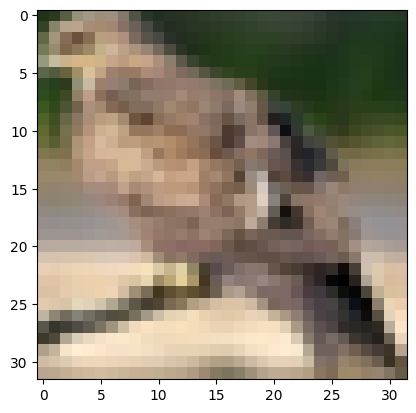

Label: 2


In [55]:
img = train_features[0]
label = train_lables[0]
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")

In [56]:
import torch.nn as nn
from torchvision.models import resnet18

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")



Using cuda device


In [57]:
# 사전 훈련된 ResNet 모델 불러오기
model = resnet18(pretrained=True)
num_features = model.fc.in_features # cifar10 분류를 위해 마지막 fully connected layer 수정
model.fc = nn.Linear(num_features, 10)
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [58]:
# 손실 함수와 옵티마이저 정의

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [59]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    pred= model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [60]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X,y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred,y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \fake")

In [61]:
epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.589955  [    0/50000]
loss: 1.157761  [ 6400/50000]
loss: 1.282183  [12800/50000]
loss: 0.967783  [19200/50000]
loss: 0.853954  [25600/50000]
loss: 0.905524  [32000/50000]
loss: 0.693090  [38400/50000]
loss: 0.815233  [44800/50000]
Test Error: 
 Accuracy: 68.4%, Avg loss: 0.935733 ake
Epoch 2
-------------------------------
loss: 0.662979  [    0/50000]
loss: 1.042683  [ 6400/50000]
loss: 0.800952  [12800/50000]
loss: 0.693768  [19200/50000]
loss: 0.596730  [25600/50000]
loss: 0.564601  [32000/50000]
loss: 0.703423  [38400/50000]
loss: 1.051243  [44800/50000]
Test Error: 
 Accuracy: 74.8%, Avg loss: 0.762997 ake
Epoch 3
-------------------------------
loss: 0.683416  [    0/50000]
loss: 0.559640  [ 6400/50000]
loss: 0.667572  [12800/50000]
loss: 0.650112  [19200/50000]
loss: 0.792575  [25600/50000]
loss: 0.456755  [32000/50000]
loss: 0.692246  [38400/50000]
loss: 0.823722  [44800/50000]
Test Error: 
 Accuracy: 77.4%, Avg loss: 0.678216 